Adaptive Distances
==================

In this example we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is possible to define arbitrary adaptive distances via the DistanceFunction.update() method.

To illustrate this feature, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('DistanceFunction')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1*scipy.randn(),
            'ss2': 2 + 10*scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as1.db")
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:Epsilon:initial epsilon is 7.443043490034237
INFO:History:Start <ABCSMC(id=15, start_time=2018-03-14 10:57:40.740023, end_time=None)>
INFO:ABC:t:0 eps:7.443043490034237
INFO:ABC:t:1 eps:5.020600640066332
INFO:ABC:t:2 eps:3.432321750699897
INFO:ABC:t:3 eps:2.2819740451109403
INFO:ABC:t:4 eps:1.5826505695166921
INFO:ABC:t:5 eps:1.1526002491421758
INFO:ABC:t:6 eps:0.8419495490450708
INFO:ABC:t:7 eps:0.566041842654108
INFO:History:Done <ABCSMC(id=15, start_time=2018-03-14 10:57:40.740023, end_time=2018-03-14 10:58:06.752193)>


Let us visualize the results for the non-adaptive distance:

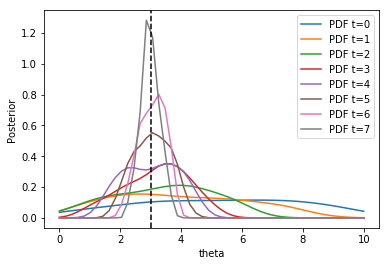

In [3]:
fig, ax = pyplot.subplots()
for t in range(history1.max_t + 1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

Second, we consider an adaptive Euclidean distance:

In [4]:
distance = pyabc.WeightedPNormDistance(p=2, adaptive=True)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as2.db")
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.5228053709089054, 'ss2': 0.1500503036714985}
INFO:Epsilon:initial epsilon is 1.946468482264764
INFO:History:Start <ABCSMC(id=18, start_time=2018-03-14 10:58:07.277589, end_time=None)>
INFO:ABC:t:0 eps:1.946468482264764
DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.38946656776496275, 'ss2': 0.1456230653344168}
INFO:ABC:t:1 eps:1.04106828459001
DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.7756090954859316, 'ss2': 0.13659256397257497}
INFO:ABC:t:2 eps:0.9920143393120804
DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.9908494085632361, 'ss2': 0.14491173250803135}
INFO:ABC:t:3 eps:0.8018565409732104
DEBUG:DistanceFunction:update distance function weights = {'ss1': 2.3508164211691924, 'ss2': 0.15743911566592905}
INFO:ABC:t:4 eps:0.9132652429746735
DEBUG:DistanceFunction:update distance function weights = {'ss1': 3.1230349280898446, 'ss2': 0.15672742060924216}
I

In the debug output of abc.run above, it can be seen how the weights evolve over time. Let us visualize the results for the adaptive distance:

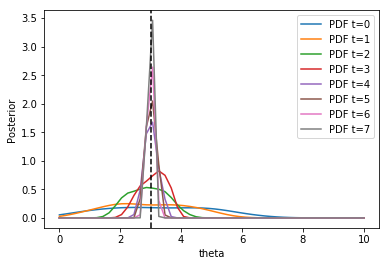

In [5]:
fig, ax = pyplot.subplots()
for t in range(history2.max_t + 1):
    df, w = history2.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

We observe some differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$.